## Lab 3 Assignment - 4/14/2019 - Part 3
### Brent Biseda <br> Mike Hardy <br> Christoph Jentzsch

# 1. Introduction

Few public problems have worried Americans as persistently as crime. When people are asked in opinion surveys to list the problems that concern them most, the threat of crime typically comes at or near the top of the list. As such, this is one of the [few areas with broad bipartisan support](https://www.people-press.org/2018/10/15/little-partisan-agreement-on-the-pressing-problems-facing-the-u-s/graphic1-7/). 

CBM-Consultants prepared this analysis for the North Carolina Governor's Office, as well as for local and municipal executive offices, to provide an actionable plan to reduce crime in counties across the state in preparation for the coming election. The analysis includes variables from a study by Cornwell and Trumball which describe multiple facets of the North Carolina population, including demographics, criminal justice system, wages, and other variables. 

CBM-Consultants will provide policy recommendations by investigating the dependent variable, crime rate, against the other independent variables.  We assume that the campaign is interested in recommendations that most reduce crime rates, and not mere partisan or political expediency.

#### 1.1 Research Question: What factors are related to crime? 

Of the many factors that affect crime rates, we want to clearly differentiate factors that are inside vs. outside a county's or government's locus of control.  Our research is primarily focused on the following question:
- How can a local government enact policies that will reduce crime rates, despite differences in their constituency and resources?

# 2. Understanding the Data: Cleaning and Exploratory Data Analysis

In [2]:
library(ggplot2)
library(psych)
library(tidyverse)
library(car)
library(lmtest)
library(sandwich)
library(stargazer)
 # Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 # R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 

In [3]:
# load the data frame
data <- read.csv("crime_v2.csv")
# run fundamental EDA analytics
stargazer(data, type="text")


Statistic N   Mean   St. Dev.   Min   Pctl(25) Pctl(75)    Max   
-----------------------------------------------------------------
county    91 101.615  58.794   1.000   52.000  152.000   197.000 
year      91 87.000   0.000   87.000   87.000   87.000   87.000  
crmrte    91  0.033   0.019    0.006   0.021    0.040     0.099  
prbarr    91  0.295   0.137    0.093   0.206    0.344     1.091  
prbpris   91  0.411   0.080    0.150   0.365    0.457     0.600  
avgsen    91  9.647   2.847    5.380   7.340    11.420   20.700  
polpc     91  0.002   0.001    0.001   0.001    0.002     0.009  
density   91  1.429   1.514   0.00002  0.547    1.568     8.828  
taxpc     91 38.055   13.078  25.693   30.662   40.948   119.761 
west      91  0.253   0.437    0.000   0.000    0.500     1.000  
central   91  0.374   0.486    0.000   0.000    1.000     1.000  
urban     91  0.088   0.285    0.000   0.000    0.000     1.000  
pctmin80  91 25.495   17.017   1.284   9.845    38.142   64.348  
wcon     

## Random Sampling Assumption
The data has 97 rows, 6 of which are NA and one of which is a duplicate, leaving a total of 90 rows for the 100 total counties of North Carolina.  

These 10 missing counties could represent important aspects of the data, such as counties where either a metropolitan police force or a rural state law enforcement agency replaces a county sheriff's office.  Missing 10% of the data may present significant challenges when interpreting the data and judging outliers, but we will assume these 10% missing counties are randomly missing, preserving the OLS assumption.

## Nature of Police-Force Data and Sample Validity
A very important detail for interpreting the data is the nature of its reporting.  The values for this data come from multiple sources, including the FBI's *Uniform Crime Report*.  Typically, this would not be an issue for such an analysis, but the lack of transparency by Cornwell and Trumbull leads us to believe that they overlooked a key feature of the FBI data that may make interpreting the data difficult:

- the FBI data, when retrieved by county, [only provides the data for the county law enforcement agencies](https://ucr.fbi.gov/additional-ucr-publications/ucr_handbook.pdf/view) (not any city or state law enforcement agencies within that county)

- to get *county* totals (not *county agency* totals), Cornwell and Trumbull would have to notate dozens of instances where enforcement [agencies spread across multiple counties in the FBI system](https://crime-data-explorer.fr.cloud.gov/)

- outside of the FBI data, the rest of the data assumes that each observation represents the whole county

- thus, it is possible that the FBI data would only represent the crime information in areas within a county not served by other law enforcement agencies. 

If this suspected oversight were true, it presents a significant challenge to making strong policy recommendations: within the FBI dataset, 10 (53%) of the NC agencies serving populations of 100,000 or greater are **not** labeled as "county agencies" by the FBI. Below is a table of Wake County's data for the year in question compared to the municipal-agency of the largest city in Wake County, Raleigh, demonstrating there is no "county-level roll-up" aggregation in the data set.

![PoliceCountyVsCity](FBI_Uniform_Crime_Report_Example.PNG)

From this point forward, we will assume that the FBI data was tabulated validly, to preserve both interpretation of data and the assumption of random sampling.

## Addressing Issues with Unusual Numbers
### Probability and Rate variables
In the data there were several observations that were NA, but, more significantly, that the variable "probability of conviction" ('prbconv') has a typo "\`" in it, again questioning the validity of the data acquisition process. 

After removing the typo in 'prbconv', we see another issue with this variable. It has more than 5 values above 1. Knowing that a probability greater than 1 is impossible, we have three different possible interpretations:  
1. There were additional mistakes in the data
2. These data points are not comparable due to the methodology used for data collection:  The original paper says the probability of conviction is "usually conditional on arrest." That uncertainty casts doubt on the comparability of the data.
3. Since the lab instruction stated it was merely a ratio, we could interpret that there were areas that had more convictions than arrests (which would imply that not only did they have a very high conviction rate, but they "threw the book" at the accused for multiple convictions).

Probabilities $\geq$ 1 are also present in the variable "probability of arrest" ('prbarr'), in this case the third interpretation of it being a ratio would mean there are counties who tend to arrest multiple people for one reported crime.  We leave the variables as is, accepting the third interpretation that these probabilities are ratios despite the variable names.

### Unrealistic values and Outliers
We exclude service industry weekly average wage with more than \\$2000. We must exclude this data point as it is not realistic that a particular county could have service industry employees making on average more than \\$100,000 (\\$250,000 in 2019) in wage annually.  

Additionally, we remove the population density point that implied a county with fewer than 1 inhabitant.  Additional clarification can be found in the comments in the code block below.

## Clarifying Regions
We combine all the regional data into a single variable, by making the assumption that counties not coded as Central nor West will be coded as East, based on the geography of the state as [North Carolina's government](https://www.sosnc.gov/divisions/publications/kids_page_geography) recognizes three regions, as seen below, that correspond to our assumption. 

<img src="NCSecStateRegionMap.gif" style="height:300px">

## Creating a variable to represent Relative Economic Strength
Over a third of the variables are average wages for various sectors.  This data is difficult to interpret without clearer definitions of each sector or its relative size. Thus, we create a testing variable, *'wageRank'*, that takes the average normalized percent rank for each county across all of the different economic sectors. This will allow us to test our wage data with a single aggregate variable.

## Adjusting Variable Scales

As our data set consists of variables that are often better interpreted through logarithmic transformations, we will adjust our variables' units to increase both our ease of interpretation and transformation.  This will ensure all probability variables are on the same scale.

In [4]:
Variables = (colnames(data[,c(3:6,8:9,14,19)]))
Description = c("crimes committed per person",
                           "probability of arrest", 
                           "probability of conviction",
                          "probability of prison sentence",
                          "police per capita",
                          "percent minority, 1980",
                          "people per sq mile",
                          "weekly wages service industry")

Transformations.and.Adjustments = c("x1000 to reflect crimes per 1,000 people",
                           "x100 to interpret one unit as one percent", 
                           "x100 to interpret one unit as one percent",
                          "x100 to interpret one unit as one percent",
                          "x1000 to reflect police per 1,000 people",
                          "None needed (already adjusted)",
                          "x100 for people per 10 square miles, removed impossible value",
                          "removed higly improbable value")
adjusted.variables = data.frame(Variables, Description, Transformations.and.Adjustments)
adjusted.variables

Variables,Description,Transformations.and.Adjustments
crmrte,crimes committed per person,"x1000 to reflect crimes per 1,000 people"
prbarr,probability of arrest,x100 to interpret one unit as one percent
prbconv,probability of conviction,x100 to interpret one unit as one percent
prbpris,probability of prison sentence,x100 to interpret one unit as one percent
polpc,police per capita,"x1000 to reflect police per 1,000 people"
density,"percent minority, 1980",None needed (already adjusted)
pctmin80,people per sq mile,"x100 for people per 10 square miles, removed impossible value"
wser,weekly wages service industry,removed higly improbable value


In [5]:
# Cleaning the data, setting values to NA
## Read in the file, exclude the bottom 6 rows of NAs
data <- read.csv("crime_v2.csv")
data <- na.exclude(data)

## Remove duplicate entries (of which there is one)
data <- unique(data[, ,])

# fix the conviction variable by eliminating the punctuation and changing
# to numeric.
data$prbconv[data$prbconv %in% c('`','')] <- NA
data$prbconv <- as.numeric(as.character(data$prbconv))

# For transformations and ease of interpretation, crime rate will be scaled to reflect
# crimes per 1000 people
data$crmrte <- data$crmrte*1000

# For transformations and ease of interpretation, all the different ratios 
# associated with crime rate, will be scaled by 100
data$prbarr <- data$prbarr*100
data$prbconv <- data$prbconv*100
data$prbpris <- data$prbpris*100
data$mix <- data$mix*100

# For transformations later on, polpc won't do well with logarithms, due to its small values.
# We will be scaling this variable to be police per 1000 people.
data$polpc <- data$polpc*1000

# For transformations later on, density would benefit from a scaling of people per 10 square miles
data$density <- data$density*100

# For transformations later on, pctymle should be converted to a scale of 100, like pctmin80 is.  
# This will help with interpretability as less as transformations.
data$pctymle <- data$pctymle*100


# Set up the "East" flag, and create a single variable for region
data$east <- 0
data$east[data$central == 0 & data$west == 0] <- 1 
data$region[data$central == 1] <- "Central"
data$region[data$east == 1] <- "East"
data$region[data$west == 1] <- "West"
data$region <- factor(data$region)

# Density has a weird value as well: 0.00002.  The largest county in all
# of North Carolina is 1,562 sq mi.
# With that density, they would have 1,562 sq mi * 0.00002 = 0.03 people
# living there, which is impossible. Thus, that data point needs to be ignored.
data$density[data$density < 0.01] <- NA

# There is an odd value in service wages.  At $2177 per week, that means
# the average service yearly salary in that county is $113,204 in 1987 dollars,
# translating to $250,231.50 inflation-adjusted dollars.
# While such salaries exist in the service sector, this kind of average is 
# improbable or displays a population so unique, that it wouldn't belong in the model.
data$wser[data$wser > 2000] <-NA

# Wage aggregation (purpose discussed later)
# This is an attempt to establish economic strength of an area by averaging
# their percent rank on the log-normal distribution This is based on our EDA
# that showed that these data were better described on a logarithmic scale.
data$wageRank <- (pnorm(log(data$wloc), mean = mean(log(data$wloc)), 
                        sd = sd(log(data$wloc))) + 
pnorm(log(data$wcon), mean = mean(log(data$wcon)), sd = sd(log(data$wcon))) +
pnorm(log(data$wtuc), mean = mean(log(data$wtuc)), sd = sd(log(data$wtuc))) +
pnorm(log(data$wtrd), mean = mean(log(data$wtrd)), sd = sd(log(data$wtrd))) +
pnorm(log(data$wfir), mean = mean(log(data$wfir)), sd = sd(log(data$wfir))) +
pnorm(log(data$wser), mean = mean(log(data$wser), na.rm = TRUE), 
      sd = sd(log(data$wser), na.rm = TRUE)) +
pnorm(log(data$wmfg), mean = mean(log(data$wmfg)), sd = sd(log(data$wmfg))) +
pnorm(log(data$wfed), mean = mean(log(data$wfed)), sd = sd(log(data$wfed))) +
pnorm(log(data$wsta), mean = mean(log(data$wsta)), sd = sd(log(data$wsta))))/9

## Exploratory Analysis for Distributions and Outliers
Our Exploratory data analysis revealed that one county, 115, is extreme in many variables.  It is highlighted as the red dot below in the scatterplot matrix.

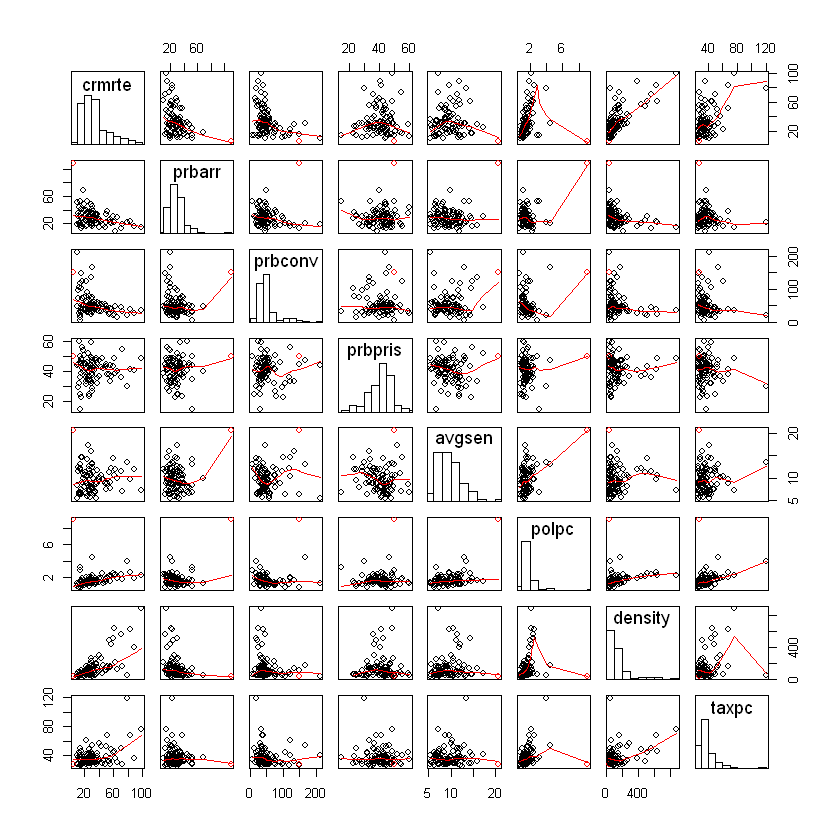

In [6]:
## Create a function which will allow histograms down the diagonal of a panel matrix
panel.hist <- function(x, ...)
{
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(usr[1:2], 0, 1.5) )
    h <- hist(x, plot = FALSE)
    breaks <- h$breaks; nB <- length(breaks)
    y <- h$counts; y <- y/max(y)
    rect(breaks[-nB], 0, breaks[-1], y)
}

# Colors for the extreme outlier
colorOut <- ifelse(
    data$county == 115,
    'red',
    'black')

# 
options(repr.plot.width=7, repr.plot.height=7)
pairs(data[,3:10], col=colorOut,
     diag.panel=panel.hist, 
     panel = panel.smooth)

### Examination and Removal of County 115
We investigated county 115 as it had extreme values in many variables (representing either the minimum or maximum of a third of all variables).  An observation full of such extremes is likely not representative of inferential population, likely with a large influence that may ultimately detract from the interpretation of the model. 

To assess whether County 115 should be removed, we performed a statistical analysis to see if it is truly representative of the population.  

1. We performed one-sample z-tests across all of the variables and found their p-values.  With 90 observations we selected $\alpha$ = 1/90, about 0.0111, two-sided, as our cut-off for statistical significance of outliers, to be conservative with our inclusion or exclusion of our estimate and to have it represent the chance of one value per variable.  County 115 had  5 times as many extreme variables than expected for an observation with extreme values and was on average in the top 0.2% of most extreme across all variables, suggesting that County 115 is not the same population.

2. When included, County 115 had a Cook's D greater than 1 in our models.  We chose not to display those results later on to not distract from the flow of the paper.

In [7]:
## Testing the Extremeness of County 115
## Calculating the p value of a z test for each variable
test <- data.frame(county=data[,1], cbind(pnorm(-abs(scale(log(data[,c(3,9:10)])))), 
                                          pnorm(-abs(scale(data[,c(4:8, 14,28)])))))

#  Set alpha and create a function to check if met
alpha <- 1/90
checksig <- function(x){
    ifelse(x < alpha/2, 1, 0)
}

# Create a variable with number of significant observations
test$extremity <- rowSums(apply(test[,c(2:11)], 2, checksig))

# Print Results
print("Here are the counties with at least one value in any variable in the top 1% most extreme expected values:")
head(test[order(-test$extremity),c(1,12)],8)

# Calculate the average extremity across all variables
AvgExtremity <- data.frame(county=data[,1],
                           meanExtremeValue = rowMeans(1-cbind(-abs(scale(log(data[,c(3,9:10)]))),
                                                            -abs(scale(data[,c(4:8, 14,28)])))))
maxextreme = 115

# Print Results
paste("County",maxextreme, 
      "has an average extremeness across all variables in the top", 
       round((1-pnorm((AvgExtremity[AvgExtremity$county==maxextreme,2])))*100,2), 
       "% of most extreme values for counties in this data. ")

## This model will be discussed and built later, but is included later to illustrate this outlier
ExampleModel <- lm(log(crmrte) ~ prbarr+prbconv + prbpris+log(avgsen) + log(wser) +
                   log(polpc)*(log(wloc) + log(wsta) + log(wfed) +log(taxpc)) +  
                   log(density)*log(taxpc)*pctmin80 + region, data = data) 
## Illustration of Cook's D
cooksd <- cooks.distance(ExampleModel)
influential <- as.numeric(names(cooksd)[(cooksd > 1)])  # influential 
paste("County ",data[influential,1],
      "has a Cooks D greater than 1 if it were left in our final model")

[1] "Here are the counties with at least one value in any variable in the top 1% most extreme expected values:"


,county,extremity
51,115,5
53,119,2
90,195,2
2,3,1
19,41,1
25,55,1
58,131,1
1,1,0


[1] "County 115 has an average extremeness across all variables in the top 0.01 % of most extreme values for counties in this data. "

[1] "County  115 has a Cooks D greater than 1 if it were left in our final model"

In [8]:
## Removing county 115, since it has extremely influential values, 
# including the max and min for the following variables:
# crmrte min, prbarr max, prbconv 2nd to max, prbpris max, avgsen max,
# polpc max, pctmin80 min, mix max

data <- subset(data,county != 115)

## The Assumptions of Normality and Transformations
After the exploratory data analysis above, we found several variables better fit log-normal distributions.

Notably, the dependent variable "Crime Rate" ('crmrte') better fit a log-normal distribution.  We demonstrate this by both comparing the histograms visually and then by running a Sharpiro-Wilk Normality test to show that the data greatly benefits from the transformation.  Considering the strictness of the Shapiro-Wilk test, we are confident in this transformation.

Thus, our models will be semi-elastic for 'crmrte'.


	Shapiro-Wilk normality test

data:  data$crmrte
W = 0.8826, p-value = 8.211e-07


[1] "We reject the null hypothesis of the Shapiro Wilk test that crmrte (untransformed) is normal. "



	Shapiro-Wilk normality test

data:  log(data$crmrte)
W = 0.98301, p-value = 0.2973


[1] "We fail to reject the null hypothesis of the Shapiro Wilk test for log(crmrte), suggesting that it is normal:"


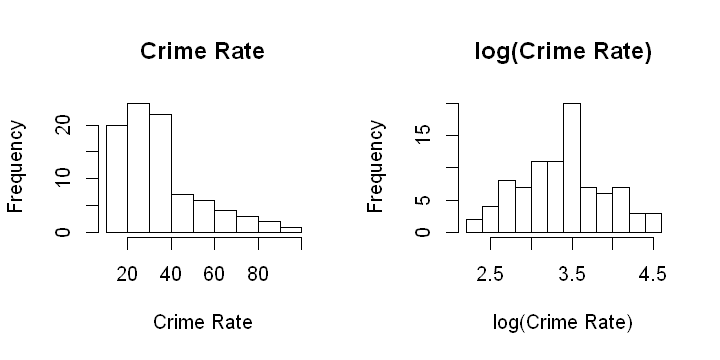

In [9]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
hist(data$crmrte, main = "Crime Rate",xlab = "Crime Rate")
hist(log(data$crmrte), main = "log(Crime Rate)", xlab = "log(Crime Rate)")

shapiro.test(data$crmrte)
print("We reject the null hypothesis of the Shapiro Wilk test that crmrte (untransformed) is normal. ")

shapiro.test(log(data$crmrte))
print("We fail to reject the null hypothesis of the Shapiro Wilk test for log(crmrte), suggesting that it is normal:")

Other variables also better fit log-normal distributions. "People per sq. mile" ('Density'), "Police per capita" ('polpc'), and "tax revenue per capita" ('taxpc') could all benefit from a log-normal distribution to meet our assumptions. Below, we examine Q-Q plots of our variables to evaluate our normality assumption.  We can see that some of these variables are not normally distributed and we choose to transform the values with a logarithm.

'Prbarr', "Average sentence" ('avgsen'), and "Offence mix" ('mix') all meet the Shapiro-Wilk test's levels of stringency at 0.05 after the transform, 'polpc' and 'density' greatly improved.

Warning message:
"Removed 1 rows containing non-finite values (stat_qq)."Warning message:
"Removed 1 rows containing non-finite values (stat_qq_line)."

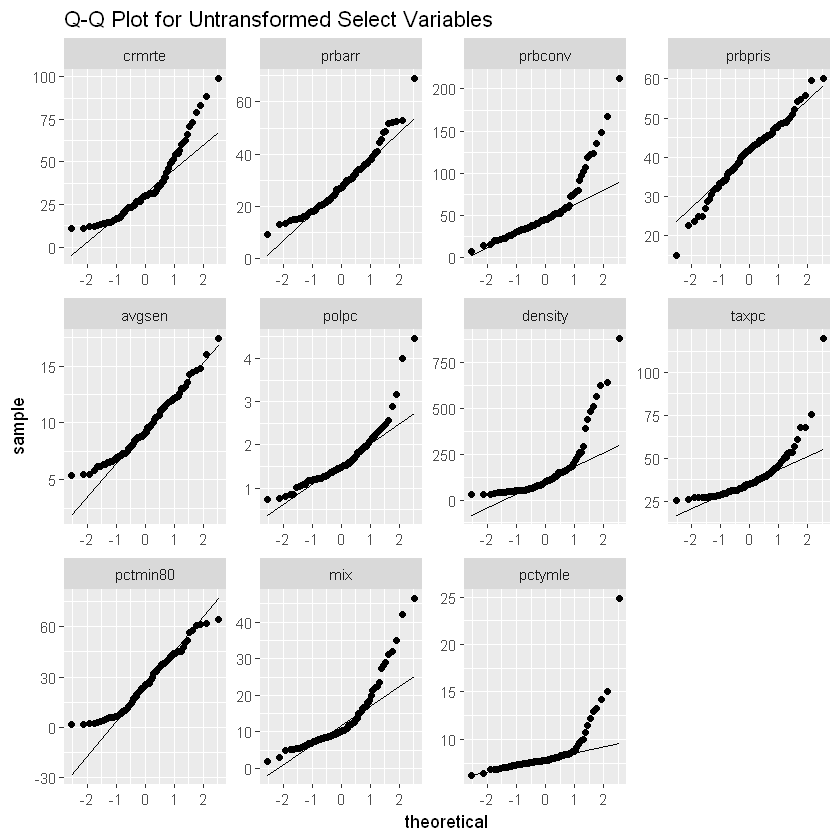

In [10]:
options(repr.plot.width=7, repr.plot.height=7)
gather(data, condition, measurement, c(crmrte:taxpc, pctmin80, mix, pctymle), 
       factor_key = TRUE) %>%
  ggplot(aes(sample = measurement)) + facet_wrap(~ condition, scales = "free") +
stat_qq() + stat_qq_line() +
  ggtitle("Q-Q Plot for Untransformed Select Variables")

Warning message:
"Removed 1 rows containing non-finite values (stat_qq)."Warning message:
"Removed 1 rows containing non-finite values (stat_qq_line)."

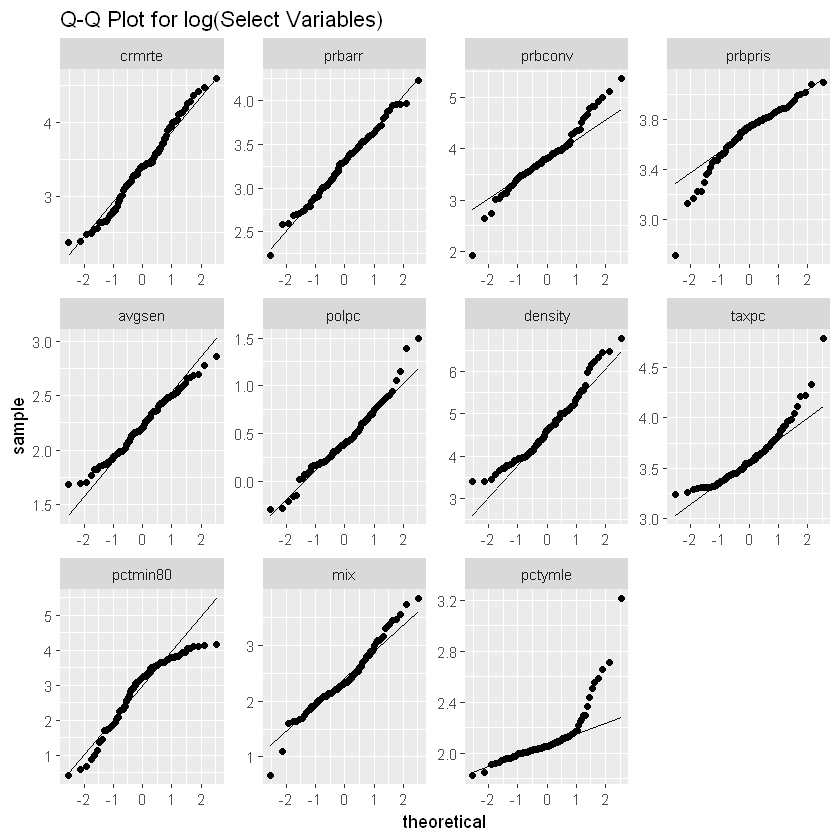

In [11]:
## And now the log comparison to each of our 
data_log <- log(data[,c(1:26,28)])
options(repr.plot.width=7, repr.plot.height=7)
gather(data_log, condition, measurement, 
       c(crmrte:taxpc, pctmin80, mix, pctymle),
       factor_key = TRUE) %>%
  ggplot(aes(sample = measurement)) + facet_wrap(~ condition, scales = "free") +
    stat_qq() + stat_qq_line() +
  ggtitle("Q-Q Plot for log(Select Variables)")

In [12]:
for (c in colnames(data[,c(4:5,7:9,24)])){
    print(paste("Shaprio.test p-value for Untransformed", 
                c, ":", round(shapiro.test((data[,c]))$p.value,5)))
    print(paste("Shaprio.test p-value for Log of", 
                c, ":", round(shapiro.test(log(data[,c]))$p.value,5)))
}

[1] "Shaprio.test p-value for Untransformed prbarr : 9e-04"
[1] "Shaprio.test p-value for Log of prbarr : 0.95943"
[1] "Shaprio.test p-value for Untransformed prbconv : 0"
[1] "Shaprio.test p-value for Log of prbconv : 0.02636"
[1] "Shaprio.test p-value for Untransformed avgsen : 0.01688"
[1] "Shaprio.test p-value for Log of avgsen : 0.48594"
[1] "Shaprio.test p-value for Untransformed polpc : 0"
[1] "Shaprio.test p-value for Log of polpc : 0.03803"
[1] "Shaprio.test p-value for Untransformed density : 0"
[1] "Shaprio.test p-value for Log of density : 0.00299"
[1] "Shaprio.test p-value for Untransformed mix : 0"
[1] "Shaprio.test p-value for Log of mix : 0.05005"


From the comparison of the Q-Q Plots above we can see that some of the variables demonstrate more normality when transformed by the log function.  According to the Shapiro.test, a number of our independent variables' assumptions of normality will benefit greatly from this transformation. 

### Transformations of the Wage variables
By evaluating the wage data for normality with the q-q plots below, we analyze whether a particular variable is normal.

#### Q-Q Plots for Wage Data to Assess Normality

Warning message:
"Removed 1 rows containing non-finite values (stat_qq)."Warning message:
"Removed 1 rows containing non-finite values (stat_qq_line)."

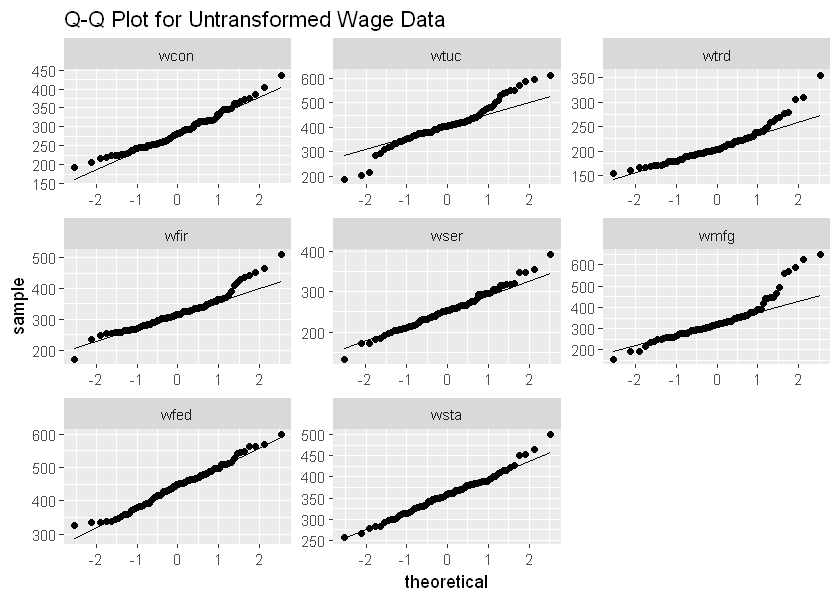

In [13]:
#Wage Data QQ Plots
options(repr.plot.width=7, repr.plot.height=5)
gather(data, condition, measurement, c(wcon:wsta), factor_key = TRUE) %>%
  ggplot(aes(sample = measurement)) + facet_wrap(~ condition, scales = "free") + 
    stat_qq() + stat_qq_line() + 
  ggtitle("Q-Q Plot for Untransformed Wage Data")

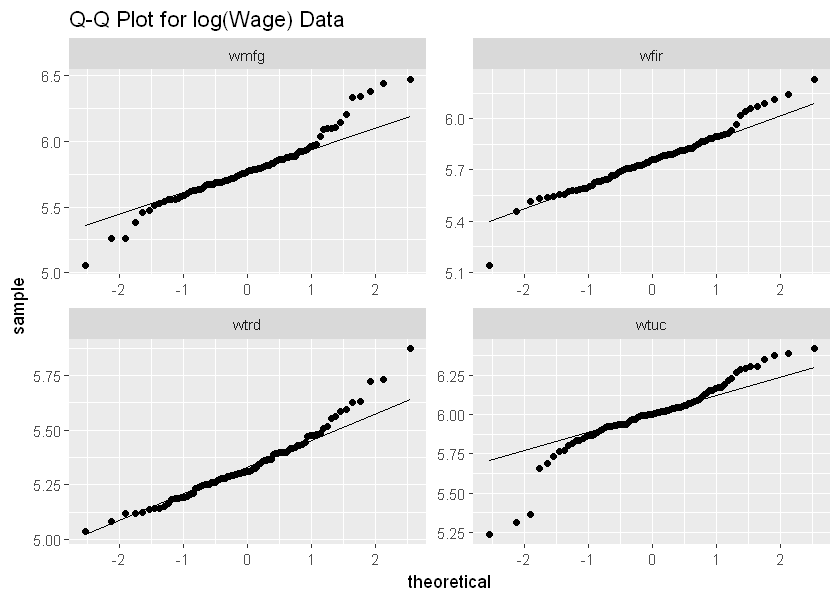

In [14]:
#Log(Wage) QQ Plots for select variables
options(repr.plot.width=7, repr.plot.height=5)
gather(data_log, condition, measurement, c(wmfg, wfir, wtrd, wtuc), 
       factor_key = TRUE) %>%
  ggplot(aes(sample = measurement)) + facet_wrap(~ condition, scales = "free") +
    stat_qq() + stat_qq_line() +
  ggtitle("Q-Q Plot for log(Wage) Data")

Many of these wage variables are approximately normal without any transformation. "Weekly wages for the construction industry" ('wcon'), "weekly service industry wage" ('wser'), "weekly federal employee wage" ('wfed'), "weekly local government wage" ('wloc') and "weekly state employee wage" ('wsta') all appear to be roughly normal. By applying a log-transform to the remaining wage data, we can approach normality for the remaining following categories: "weekly manufacturing wages" ('wmfg'), "weekly financial insurance and real estate wages" ('wfir'), "weekly wholesale retail trade wage" ('wtrd'), and "weekly transportation utility wage" ('wtuc').  

Summarized below are the p-values from the Shapiro-Wilk test. Some benefit from the log transform, some are practically unaffected, while others don't benefit.  

In [15]:
for (c in colnames(data[,c(15:23)])){
    print(paste("Shaprio.test p-value for Untransformed", 
                c, ":", round(shapiro.test((data[,c]))$p.value,5)))
    print(paste("Shaprio.test p-value for Log of", 
                c, ":", round(shapiro.test(log(data[,c]))$p.value,5)))
}

[1] "Shaprio.test p-value for Untransformed wcon : 0.03929"
[1] "Shaprio.test p-value for Log of wcon : 0.81528"
[1] "Shaprio.test p-value for Untransformed wtuc : 0.00301"
[1] "Shaprio.test p-value for Log of wtuc : 1e-05"
[1] "Shaprio.test p-value for Untransformed wtrd : 0"
[1] "Shaprio.test p-value for Log of wtrd : 0.00588"
[1] "Shaprio.test p-value for Untransformed wfir : 0.00075"
[1] "Shaprio.test p-value for Log of wfir : 0.01679"
[1] "Shaprio.test p-value for Untransformed wser : 0.64308"
[1] "Shaprio.test p-value for Log of wser : 0.3502"
[1] "Shaprio.test p-value for Untransformed wmfg : 0"
[1] "Shaprio.test p-value for Log of wmfg : 0.00326"
[1] "Shaprio.test p-value for Untransformed wfed : 0.43736"
[1] "Shaprio.test p-value for Log of wfed : 0.28843"
[1] "Shaprio.test p-value for Untransformed wsta : 0.36627"
[1] "Shaprio.test p-value for Log of wsta : 0.75584"
[1] "Shaprio.test p-value for Untransformed wloc : 0.11481"
[1] "Shaprio.test p-value for Log of wloc : 0.10728

### Discussion of 'pctymle'

The 'pctymle' variable does not follow a normal nor log-normal distribution. This might naively be attributed to one extreme outlier (which has nearly a quarter of the population as young male).  However, this outlier could be Cumberland County (or one of the other four counties), which hosts the nation's largest military complex: The Army's Fort Bragg.  This large complex has over 50% of its population, about 35,000 in 1987, below the age of 25.  This is only a hypothetical but suggesting that it may be possible for such an odd 'pctymle' to exist. With or without this outlier, the transformation that best helps 'pctymle' meet our normality assumption is the Power Transformation, represented by the variable  'powerpctymle'.

[1] 58 85

[1] 58 85

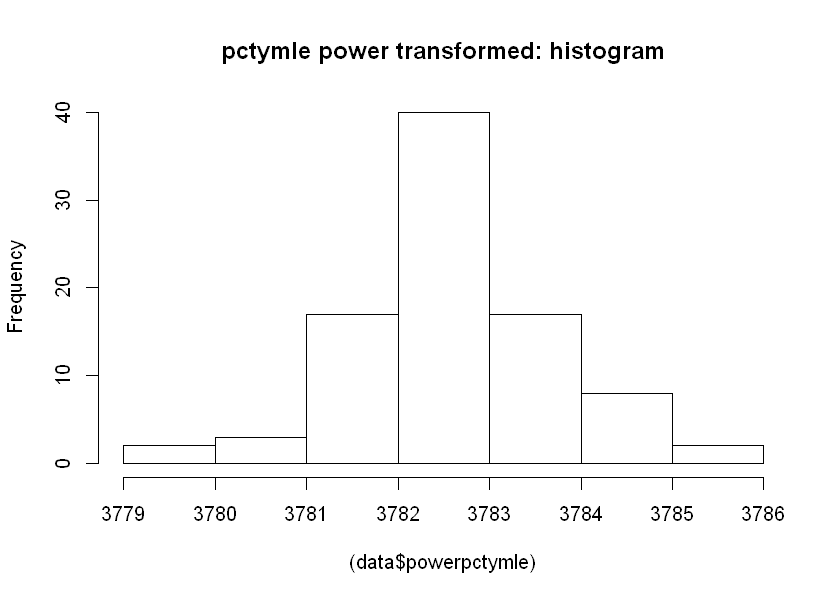

[1] 66 19

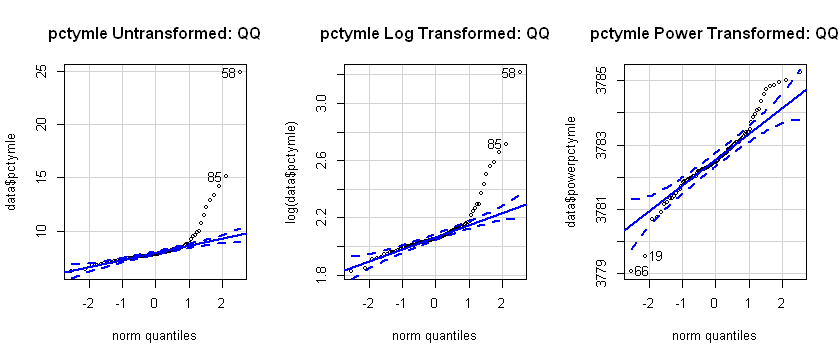

In [16]:
# Perform a PowerTransform on pctymle
geomMeanpctymle = exp(sum(log(data$pctymle)) / length(data$pctymle))
lamb = powerTransform(data$pctymle)$lambda
data$powerpctymle = (data$pctymle^lamb-1)/(lamb*geomMeanpctymle^(lamb-1))

hist((data$powerpctymle), main= "pctymle power transformed: histogram")

options(repr.plot.width=7, repr.plot.height=3)
par(mfrow=c(1,3))
qqPlot(data$pctymle, main = "pctymle Untransformed: QQ")
qqPlot(log(data$pctymle), main = "pctymle Log Transformed: QQ")
qqPlot(data$powerpctymle, main = "pctymle Power Transformed: QQ")

In [17]:
print(paste("Shaprio.test p-value for Untransformed pctymle", 
            c, ":", round(shapiro.test((data$pctymle))$p.value,5)))
print(paste("Shaprio.test p-value for powerpctymle", 
            c, ":", round(shapiro.test((data$powerpctymle))$p.value,5)))

[1] "Shaprio.test p-value for Untransformed pctymle wloc : 0"
[1] "Shaprio.test p-value for powerpctymle wloc : 0.00891"


# 3. Model Building Process

## Selection of Transformations
Based on the analyses above, we will use the following transformations for our models:
### Independent Variable Transformation
As mentioned above, the log of 'crmrte' will be used, as it already meets the criteria for normality, per the strict requirements of the Shapiro-Wilk test.

Thus, we interpret our coefficients as "a unit change in $X_1$ results in a $Y_1$% change in the crime rate."  For interpretability, any variables already being expressed in common percentages are left untransformed. 

### Transformations to Meet Assumptions of Normality 
Based on the exploratory analysis, the following variables will be log-transformed for use in our models:
- 'avgsen'
- 'density'
- 'polpc'
- 'mix'

### Transformation of Wage Variables
We are constraining the wage variables to all use the same transformations, to maintain variable comparability.

Due to the nature of wages, and the traditional econometric approach of taking the log of salaries, we will take the log of the wage data.  This decision, will also increase the ease of our interpretation, since we are using wages as a proxy for the economic strength of a county: increasing wages by 1% is clearer that increasing wages by 1 dollar. 

### Not Transforming to Ease Interpretation
We deliberately choose to keep some variables untransformed to improve interpretability.
- 'prbarr' and 'prbconv' would both benefit from a log transformation. However, 'prbpris' would worsen its approximation to normality. We choose not to transform these variables because: 
    1. We instead constrain all criminal justice ratios to have the same scale. 
    2. They are already described as 'probabilities', being ratios, which are very closely related to the percent interpretation gained from using a log-transformation on our dependent variable.
- 'pctymle' will not receive the power transformation that would help it follow a more normal distribution, due to interpretability: while controlling for 'powerpctymle' may help with OLS assumptions, we would be doing so without strong interpretation power of this 'Descriptive' variable. We will either not include pctymle in our models, or use the slightly distribution-improved log('pctymle'), with more conservative standard errors. 
- All other variables not mentioned will remain without transformations

### Transforming to Ease Interpretation
'Taxpc' did not benefit much from the log transformation. However, for practical interpretation it makes more sense to discuss it in terms of percent increases to taxes, rather than unit dollar increases per capita.  Thus, 'taxpc' will receive the log transform to aid in interpretability.

### Significance of Transformations
From this point forward, when referring to any of these variables, we will be referring to them in their transformed state. We acknowledge that some of the variables are not normally distributed, and therefore will likely benefit from robust standard errors.

## Selection of Model Variables

### Organizing Variables by Ability to be Impacted by Policy
We want to measure the effectiveness of items within a policy-maker's control (which we call 'Actionable') against the impact of factors that they cannot control (which we call 'Descriptive') that may be intrinsic to the county:
- Explanatory variables Within a policy-maker's control ('Actionable'):
    1. 'prbarr' -- proxy for the efficacy of law enforcement making arrests for reported crimes
    2. 'prbconv' -- proxy for district attorney getting convictions from the arrest (pursuing convictable crimes)
    3. 'prbpris' -- proxy for county judiciary sentencing practices
    4. 'avgsen' -- proxy for county judiciary severity of sentencing
    5. 'taxpc' -- the log transformation looks at % tax increases, instead of revenue per capita, which is more within the policy maker's control, than describing average county income (which, while less controllable by policy can act as an economic barometer).
    6. 'wsta', 'wfed', 'wloc' -- we assume that policy makers can affect the wages of government-paid employees.
- Explanatory variables more indirectly within a policy-maker's control ('Actionable'):
    1. 'wser' -- the service sector is typically a very large sector of an economy ([up to 80%](https://www.bls.gov/emp/tables/employment-by-major-industry-sector.htm), depending [on definition](https://www.bls.gov/cew/bls_naics/v1/bls_naics_app.htm#tab=hierarchy&naics=2012&hier=default)).  It [typically has lower wages](https://www.bls.gov/news.release/empsit.t19.htm) than other sectors because of the [large amounts of positions](https://www.bls.gov/opub/reports/minimum-wage/2017/home.htm) that receive minimum wage.
- Explanatory variables intrinsic to a county ('Descriptive'):
    1. 'pctmin80' 
    2. 'wageRank' (average distributed ranking for all wage data), an economic barometer, similar to 'taxpc'
    3. 'region' (East, Central, West)
    4. 'pctymle' 
    5. 'density' 
    6. All other wage variables -- for this analysis, we will assume that the other wage variables cannot be easily impacted by policy changes.
- Explanatory variable within a policy-maker's control, but not representing that in the data ('Actionable')
    1. 'polpc' -- This variable is critical for understanding the model, but it is also confounding.  We would expect areas with more crime to have more police per capita.  But this increase likely lags in response to crime rates.  The variable will need to be included in our models, regardless of its relationship to 'crmrte', because omitting it would bias our other observations away from zero. 

### Covariates
Besides the covariation of 'polpc' and 'crmrte' above, there are many variables that share relationships with one another:

1. Wage data: relative wages across sectors are often tied to one another--if a county is low in one sector, they will likely be low in others.
2. 'Density' and 'urban' variables effectively measure the same thing, but 'density' provides much greater resolution than the urban dummy variable.
3. The most problematic covariate is 'polpc' and 'crmrate':  places with more crime will likely have more police per capita--if anything, it is the opposite causality that what we would hope for (i.e. "if we add more cops, will crime decrease?")

## Omission of Variables from the Provided Dataset
Aside from the data cleaning previously described, there are select variables that we choose to exclude from our analysis.

### Exclusion of Urban Variable
Because the dataset also includes population density, we believe that it is an appropriate proxy for the 'urban' categorical variable, especially since 'urban' is arbitrarily defined by a particular density cutoff. Therefore, we choose to omit 'urban' from our analysis.

### Exclusion of Crime 'Mix' Variable
We choose to exclude 'mix' from our analysis.  This variable represents a categorization of crimes as a percent that happen face-to-face.  However, it isn't clear how to interpret this variable in terms of actionable policy.  Additionally, this variable is dependent upon crime itself, so we do not feel that it could be used to represent our overall model; the causal relationship (if there is one) would likely be from crime rate (our selected dependent variable) influencing 'mix', more so than the other direction.  It may also be a function of number of convictions as well as assault charges or other charges that can be added to arrests and is confounding for counties with convictions that exceed arrests.

We think that including this variable may bias our results away from zero since areas with smaller populations would experience more extreme effects of mix values, since a single incident of crime will result in a larger step-change in this reported variable.  In contrast, more populous counties will have more crimes in general and therefore the values are more likely to be mean centered from the central limit theorem.  

### Exclusion/Inclusion of Wage Data

We would expect that wages would be correlated within a geographic area. Therefore, while there is a total of 9 different variables that track the wages within a particular county, they are not truly independent variables. 

#### Correlation Matrix of Wage Data

In order to better understand the dependence between each wage category, we create a correlation matrix, shown below.  This allows us to determine which specific wage categories may be truly independent and therefore most useful in our analysis.

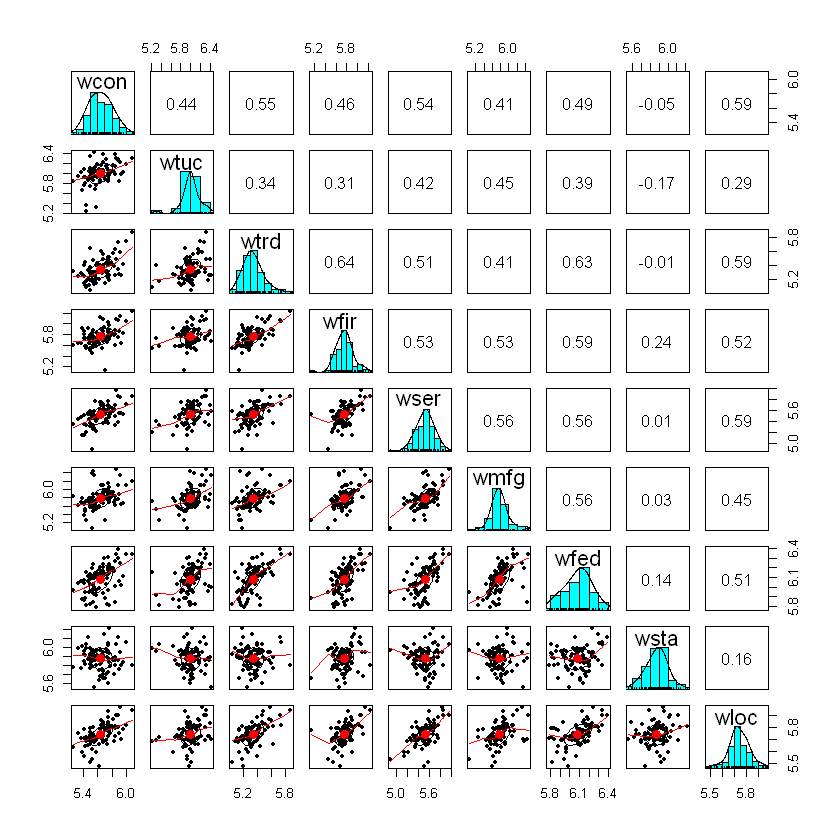

In [18]:
options(repr.plot.width=7, repr.plot.height=7)
pairs.panels(data_log[,15:23])

After examining the correlation matrix of wage variables, we can see that state employee wages and service employee wages are less correlated to the other wage categories. These two variables may merit additional consideration in our model. In contrast, the seven remaining wage variables show correlation between each other. <br>

As a simplifying assumption, we decided to limit the number of relevant variables of these seven remaining variables and select only a few as a proxy for all seven. The remaining wage variables will be omitted. On the one hand we can see that federal employee wage as well as the wage of local government employees have one the highest coefficients of correlation between all the other wage variables. Therefore, federal and local government wages seem to be the best variables to include in our model to represent the total wage outlook for each county.

This makes sense for our purposes: A campaign will be predominantly interested in the wages that it may be able to impact through policy:  federal, state and local government employees likely fall into this category (such as teachers, state law enforcement, etc.).  Also, from a policy standpoint, state minimum wage is within the purview of the Governor's Office, which, would directly impact service employee wages.

#### Tests for Impact of Removal of Variables
To test whether our interpretation of these variables will negatively impact our final model, we run some tests on mock models using just the wage data and our 'wageRank' variable.  These will include all the wages, 'wageRank', and the four focus wage variables (of 'wser', 'wfed', 'wsta', and 'wloc'), and the combination of the latter three. 

We compare overall parsimony of each of the models with an AIC test.

In [19]:
# Here we compare AIC for wage variables
AllWages <- lm(log(crmrte) ~ log(wcon) + log(wtuc) + log(wtrd) + 
               log(wfir) + log(wser) + log(wmfg) + 
              log(wfed) + log(wsta) + log(wloc) + wageRank, 
               data = data[complete.cases(data),], na.action = na.omit)

WageRank <- lm(log(crmrte) ~ wageRank, 
               data = data[complete.cases(data),], na.action = na.omit)

Focus3 <- lm(log(crmrte) ~ log(wfed) + log(wser) + log(wloc) +
             log(wsta), data = data[complete.cases(data),], 
             na.action = na.omit)

Focus3andRank <- lm(log(crmrte) ~ wageRank + log(wser) + log(wloc) + 
                    log(wsta) + log(wfed), 
                    data = data[complete.cases(data),], na.action = na.omit)

(paste("Model With All Wage Variables: ", 
       AIC(AllWages)))
(paste("Model With Wage Rank in Place of Wage Variables: ", 
       AIC(WageRank)))
(paste("Model With Wage Rank, Service Wage, and Government Wages: ", 
       AIC(Focus3)))
(paste("Model With Federal Government Wage, State Wage, Local Wage and Service Wage in Place of Wage Variables: ", 
       AIC(Focus3andRank)))

[1] "Model With All Wage Variables:  118.007131665178"

[1] "Model With Wage Rank in Place of Wage Variables:  109.524396612467"

[1] "Model With Wage Rank, Service Wage, and Government Wages:  110.158569217606"

[1] "Model With Federal Government Wage, State Wage, Local Wage and Service Wage in Place of Wage Variables:  111.951669593486"

Our AIC tests show that Wage Rank is the stronger parsimony, but that the focus four variables are more parsimonious than all of the variables combined.  

Next, we check for autocorrelation among these mock wage-only models, to see if there is any risk of violating our assumption of Random Sampling, using a Durbin-Watson test.

In [20]:
durbinWatsonTest(AllWages)

 lag Autocorrelation D-W Statistic p-value
   1     -0.06681299      2.105259   0.616
 Alternative hypothesis: rho != 0

Since we fail to reject the hypothesis that there is no autocorrelation, we next check to see whether removing 70% of the wage variables have any significant impact on the efficacy of wages' explanatory power for 'crmrte' by performing a Wald test.

In [21]:
linearHypothesis(AllWages, c("log(wcon) = 0", "log(wtuc) = 0", "log(wtrd) = 0", 
                             "log(wfir) = 0", "log(wmfg) = 0", 
                            "wageRank = 0"), vcov = vcovHC)

Res.Df,Df,F,Pr(>F)
82,NA,NA,NA
76,6,0.7057211,0.6459071


#### Omitting Wage Variables
With the Wald Test, we fail to reject the null hypothesis that the eliminated variables don't contribute significantly more to the data than the simplified model of four focus variables. It suggests that there is no difference in the joint significance of using all the wage variables and the joint significance of using our leaner model.

We will exclude the other wage data going forward and focus on these particular variables: 'wser', 'wfed', 'wsta' and 'wloc'.

While 'wageRank' may be more parsimonious, its removal didn't significantly affect the overall model. We choose to model with 'wser', 'wfed', 'wsta' and 'wloc' for their benefit in both representing the wage data and allowing for greater interpretation for policy.

## Model Assumptions 
In order to make any inference from this analysis, it is necessary to articulate the assumptions that underlie the model's validity. These six assumptions are known as the classical linear model assumptions and are listed below.

### 1. Linear in Parameters
- In order for our ordinary linear regression analysis to be valid, we assume that the relationship between our explanatory variables and the crime rate can be represented linearly.
- Potential Challenge: The true relationship between the dependent variable and explanatory variables may not be able to be represented linearly.  We will rely on the robustness of OLS models to find best estimators. 

### 2. Random Sampling
- We assume that the sample is identically distributed and independent, which means that each data point is independent is not affected by others.
- Potential Challenge: See the sections titled, "Data Count and Random Sampling" and "Nature of Police Force Data" above for more information on the quality of the data and potential non-randomness in sampling. We do not have enough information about the original dataset to ensure that this assumption holds for certain, but we can test for autocorrelation in our models. 

### 3. No Perfect Collinearity
- We suppose that the independent variables do not have a perfect linear relationship, and our initial correlation matrices suggest that this is a safe assumption for the variables we have chosen to work with. Our model output will indicate if this assumption is violated.

### 4. Zero Conditional Mean
- The error term 'u' has an expected value of zero given any value of the explanatory variable (like 'prbarr', 'avgsen' or 'taxpc').
- Potential Challenge: As we are only working with a limited set of data (e.g. we only have a slice of 1 year) and we face the situation of omitted variables that might be difficult to confirm.

### 5. Homoscedasticity
- We assume that the error term has a constant variance given any value of the explanatory variables. This means that the variance does not change independent of the amount or value of the explanatory variables.
- Potential Challenge: If this assumption does not keep up and the error term has a different variance depending on the explanatory variables, the principle of ceteris paribus would be at risk. Thus, the results of the regression would be less robust. If our model violates this assumption, we will use robust standard errors to account for the presence of any heteroscedasticity.

### 6. Normality of the Error
- The error must be normally distributed and independent of the explanatory variables. This is a very strong assumption, and in case this assumption holds it captured assumption 4 and 5. We will also evaluate this assumption with diagnostic plots showing our residuals later in this report.

# 4. Regression Model Creation and Analysis

## Model Specifications
After transforming and omitting variables, exploring the assumptions of OLS, and organizing variables by their ability to be impacted by policy, define our models around our dependent variable.

**Dependent Variable:** log('crmrte')

### Base Model: Base Model Including Actionable Explanatory Variables
We want our Base Model's explanatory independent variables to consist only of the 'Actionable' variables that policy makers might impact more directly. This model is declared as the 'Base Model'.

**Add Actionable Independent Variables:** 'prbarr', 'prbconv', 'prbpris', log('avgsen'), log('taxpc'), log('wser'), log('wfed'), log('wsta'), log('wloc'), log('polpc').  

### Model 2: Action Model Including Actionable and Descriptive Variables Without Theoretical Interactions
Model 2 seeks to increase our inference power from the Base Model. Thus, this model targets to be more predictive by adding to the base model additional 'Descriptive' attributes of a county that aren't directly changeable through policy but are very likely to have an impact on the crime rate. 
To remain a good balance between increased level of insightfulness and over complexity, the model opts for simplicity in its interpretability, which will be better for inference by policy makers. For that reason, interactions are not part of this model yet. This model is declared as the 'Action Model'.

**Add Descriptive Independent Variables:** log('density'), 'pctmin80', 'region'.


### Model 3: Predictive Model Including Actionable and Descriptive Variables With Theoretical Interactions
Model 3 tries to go a step beyond the previous models and incorporates the interaction among multiple variables. Compared to Action Model this Model 3 seeks to be highly predictive by adding additional interactions that drive an impact within the selected variables. This model is declared as the 'Predictive Model'.

**Underserved Community Interaction:** Many studies have identified that the factors of poverty, being a minority, and living in a dense environment all have compounding effects on each other.  In our predictive model, we will represent the compounding problems faced by underserved communities by a three-way variable interaction of 'pctmin80', log('density') and log('taxpc') (as a proxy for both wealth and resources for community services). 

**Enforcement Agency Efficacy Interaction:** We want to remove some of the confounding effects of police per capita (discussed above), by including factors that may affect their efficacy.  For this, we believe that the impact of police on crime will change as resources given to them change. As the 'polpc' variable contains law enforcement officers from all agencies, the 'wfed', 'wsta', and 'wloc' wage (log of wages) will act as proxy for the compensation of police, and 'taxpc' (for the reasons mentioned above) for resources available to law enforcement agencies. This interaction will consist of log('polpc') interacting each with log('wfed'), log('wsta'), log('wloc'), and log('taxpc').

This is the most comprehensive model, which best reflects the most critical interactions of these variables. Despite its increase in variables this model has strong parsimony. However, the expected gain in predictive power, may result in a loss of interpretive power.


## Model Creation

In [22]:
# Here we create the model that is loaded with everything except mix

# Variables that we can control most directly via policy, 
# Removing police per capita as it is possible that it is the confounding 
# variable that leads to increases in "crime rate"

Base <- lm(log(crmrte) ~ prbarr + prbconv + prbpris + log(avgsen) + log(polpc) +
           log(taxpc) + log(wser) + log(wsta) + log(wfed) + log(wloc), data = data)

# In addition to Base Model specific independent 
# variables for policy controlled with variables 
# that describe circumstances of a specific county and likely impact crime rate

Model2 <- lm(log(crmrte) ~ prbarr + prbconv + prbpris + log(avgsen) + log(polpc) +
             log(taxpc) + log(wser) + log(wsta) + log(wfed) + log(wloc) + log(density) +  
             pctmin80 + region, data = data)

#Only Variables we have policy control over, with police, density, 
# region and pct minority and their interactions
Model3 <- lm(log(crmrte) ~ 
             log(polpc)*(log(wloc)+log(wsta)+log(wfed)+log(taxpc)) +  # Police Resources Interaction
             prbarr+prbconv + prbpris+log(avgsen) + # Government Ratios
             log(density)*log(taxpc)*pctmin80 + # Underserved Community Interactions
             log(wser)+  # Indicator for other sectors and of minimum wage
             region, data = data)  # geographical factors

## Specification Tests

### Testing for Parsimony

In [23]:
## First we check for Parsimony to see how efficient our variables are at contributing to the overall model.

(paste("Base Model with all actionable independent variables: ", 
       AIC(Base)))
(paste("Action Model 2 with all actionable and selected descriptive variables: ", 
       AIC(Model2)))
(paste("Predictive Model 3 with all actionable, selected descriptive variables and interactions: ", 
       AIC(Model3)))

[1] "Base Model with all actionable independent variables:  57.6346714332063"

[1] "Action Model 2 with all actionable and selected descriptive variables:  -12.0396155691825"

[1] "Predictive Model 3 with all actionable, selected descriptive variables and interactions:  -37.5518199147848"

The inclusion of the additional variables in Models 2 and 3 dramatically improved the parsimony of the model, compared to the base.  As expected the Prediction Model 3, including the interactions in the Action Model 2 improved parsimony further, although the improvement is not as significant as over the base model.

### Testing for Polynomial Interactions
There may be important relationships that follow parabolic or cubic relationships to the dependent variable; we perform a RESET test on the models.

In [24]:
print("Checking for quadratic and cubic interactions on Base Model")
resettest(Base, power=2:3)
print("Checking for quadratic and cubic interactions on Action Model 2")
resettest(Model2, power=2:3)
print("Checking for quadratic and cubic interactions on Prediction Model 3")
resettest(Model3, power=2:3)

[1] "Checking for quadratic and cubic interactions on Base Model"



	RESET test

data:  Base
RESET = 0.66258, df1 = 2, df2 = 75, p-value = 0.5185


[1] "Checking for quadratic and cubic interactions on Action Model 2"



	RESET test

data:  Model2
RESET = 0.36455, df1 = 2, df2 = 70, p-value = 0.6958


[1] "Checking for quadratic and cubic interactions on Prediction Model 3"



	RESET test

data:  Model3
RESET = 0.96658, df1 = 2, df2 = 62, p-value = 0.386


No test is statistically significant. Without strong theory and a hypothesis to support our tests, we fail to reject the null hypothesis that the quadradic and cubic relationships won't contribute to either model.

### Testing for Impact of Interaction Variables

Our test for parsimony led us to ask whether that difference in parsimony is reflecting a significant difference between the Models 2 and 3.  A Wald test leads us to reject the null hypothesis and we conclude that the interactions used in Prediction Model 3 are significant.

In [25]:
# Test the removal of interaction terms, as well as pctymle and wageRank, we check the significance of the 
# Removal of these variables by comparing Model 2 and Model 3
# --> I would delete this 

waldtest(Model2, Model3, vcov=vcovHC)

Res.Df,Df,F,Pr(>F)
72,NA,NA,NA
64,8,3.478625,0.00216776


## Visually Checking Assumptions: Base Model

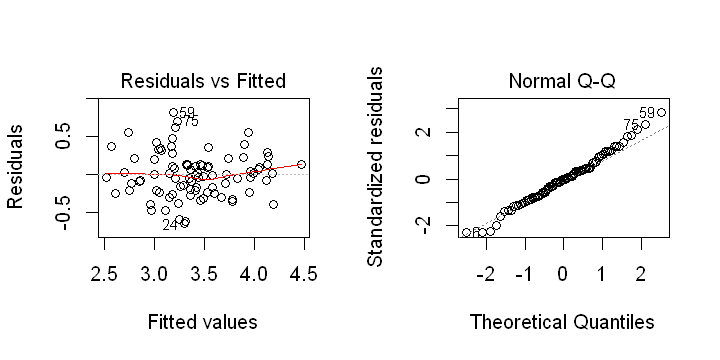

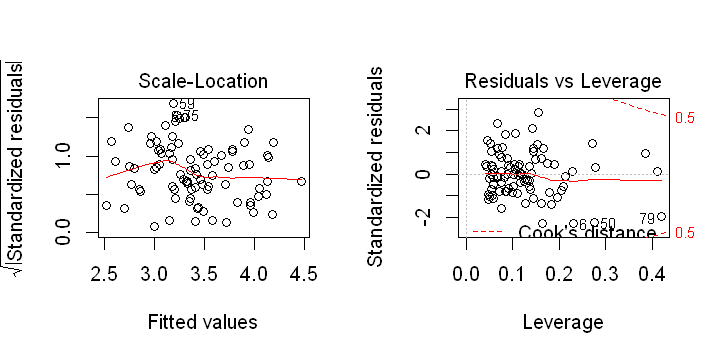

In [26]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
plot(Base)

From the graph of the residuals above, we believe that the zero conditional mean assumption is valid. We do see a moderate level of heteroscedasticity as (the root of) the standardized residuals appear to vary across our fitted values. Additionally, we can infer that our model is not overly sensitive to any specific points as Cook's distance is below 0.5 for all values. Our q-q plot suggests normality for our model.

## Visually Checking Assumptions:  Model 2

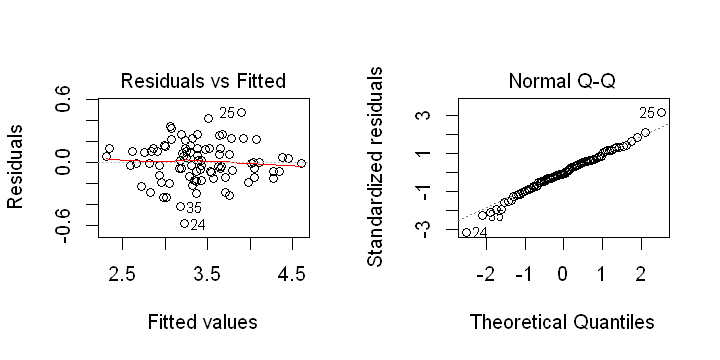

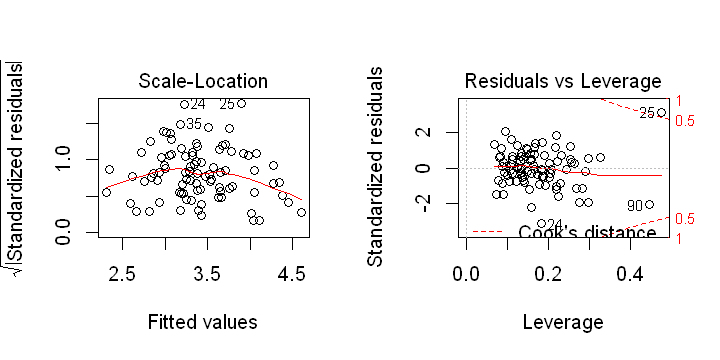

In [27]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
plot(Model2)

The zero conditional mean assumption appears validated. However, we do observe stronger heteroscedastic patterns across our fitted values' standardized residuals, with the variance decreasing at the ends. Additionally, see that the Action Model is more sensitive to specific points than the Base model; we now have 1 point with Cook's distance greater than 0.5, but still less than 1. 

## Visually Checking Assumptions: Model 3

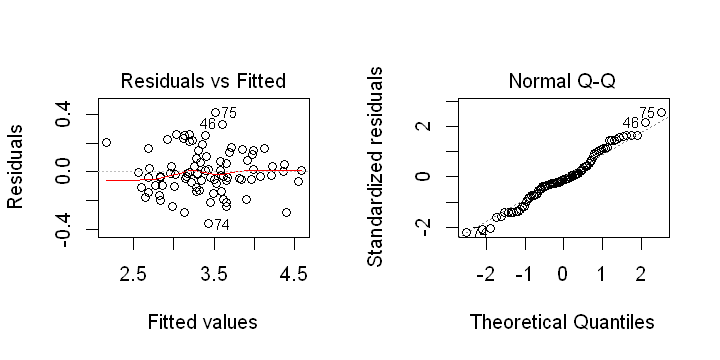

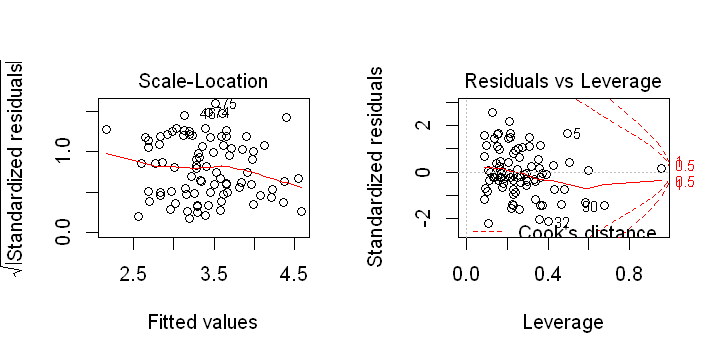

In [28]:
# Plotting Model 3
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
plot(Model3)

The zero conditional mean assumption remains approximately valid. While the Action Model was more sensitive to specific points than the Base Model, we can infer that this 3rd Prediction model is more robust and not overly sensitive to any specific points as Cook's distance is clearly below 0.5 for all values. As the previous models the q-q plot suggests that the main range of explanatory values are normal for our Prediction Model. Finally, there appears to be a slight heteroscedastic declining trend among fitted values.

## Confirming and Correcting for Heteroskedasticity

Because of the presence of concerns for heteroscedasticity among some of the models, we choose to make use of robust standard errors in our table below.  This allows us to make interpretations for statistical significance for coefficients in our model even with the presence of heteroscedasticity.

Running the studentized Breusch-Pagan test reveals that at least two of our models could benefit from more conservative standard errors.  Considering the complexity of the interactions in Model 3, even though it isn't statistically significant, we do want to be more cautious in our conclusions.  Thus, all models will receive corrected standard errors.

In [29]:
print("Base Model")
bptest(Base)
print("Action Model 2")
bptest(Model2)
print("Precictive Model 3")
bptest(Model3)

[1] "Base Model"



	studentized Breusch-Pagan test

data:  Base
BP = 24.187, df = 10, p-value = 0.00712


[1] "Action Model 2"



	studentized Breusch-Pagan test

data:  Model2
BP = 34.542, df = 14, p-value = 0.001717


[1] "Precictive Model 3"



	studentized Breusch-Pagan test

data:  Model3
BP = 15.318, df = 22, p-value = 0.8482



For the Base Model and the Action Model 2 we can reject $H_0$ as is clearly smaller than 0.05. However, the for the Prediction Model 3 we are not able to reject $H_0$. To correct for the heteroskedasticity, regardless of the outcome of the test above, we will be using more conservative coefficients for interpreting our models.

In [30]:
se.base = coeftest(Base, vcov = vcovHC)[, "Std. Error"]
se.model2 = coeftest(Model2, vcov = vcovHC)[, "Std. Error"]
se.model3 = coeftest(Model3, vcov = vcovHC)[, "Std. Error"]

## Regression Table and Comparison of Models

In [31]:
stargazer(Base, Model2, Model3, 
          type = "text",
          title="Comparison of Linear Regression Models to Predict Crime Rate",
          align=TRUE,
          style="default",
          single.row=TRUE,
          column.sep.width = "1pt",
          column.labels = c("Base", "Model 2", "Model 3"),
          se = list(se.base, se.model2, se.model3),
          dep.var.labels = c("log(crmrte)"),
          star.cutoffs = c(0.05, 0.01, 0.001),
          notes = c("* p<0.05; ** p<0.01; *** p<0.001"))


Comparison of Linear Regression Models to Predict Crime Rate
                                                           Dependent variable:                          
                                 -----------------------------------------------------------------------
                                                               log(crmrte)                              
                                          Base                   Model 2                 Model 3        
                                           (1)                     (2)                     (3)          
--------------------------------------------------------------------------------------------------------
prbarr                              -0.020*** (0.005)       -0.017*** (0.003)       -0.018*** (0.003)   
prbconv                             -0.007*** (0.001)       -0.006*** (0.001)       -0.006*** (0.001)   
prbpris                              0.0002 (0.006)          -0.004 (0.003)          -0.001 (0.003

## 4.3 Model Discussion

By purely comparing the statistics the Action Model 2 and Predictive Model 3 appear to be materially superior to the Base Model, especially with an impressive Adjusted-R-squared of about 0.9. However, it must be taken into consideration that, although Predictive Model 3 provides greater predictive power, it makes it difficult to interpret the interaction variables from a policy standpoint, such as explaining how the interactions between polpc and the proxies for resources can be interpreted. We want a model that that be more easily interpreted.  

### Key Observations
By looking at all three models, a few key ideas stand out that highlight the differences between the predictive model 3 and the other models: 
1. In every model, 'prbarr' and 'prbconv' are significant, whereas 'prbpris' and 'avgsen' are not.
2. As expected, for Base and Model 2, polpc is significant and increases with crime rate.  Model 3, which attempts to model both the effects of underserved communities and interactions of resources and police. Has a non-significant value which is, appropriately, negative. 
3. Interestingly, the Base and Model 2 both show wser as negatively significant.  Model 3, while also negative, is not significant.
4. The variables representing underserved urban communities were significant for both Model 2 and 3, as well as all of their interactions in Model 3.  This clearly indicates that the Base model lacks strong explanatory variables.
5. Very interesting is that, after accounting for taxpc in multiple interactions in Model 3, it became the strongest log-normed value, where a 1% increase in taxes received is tied to a 4.6% decrease in crime rate.  However, the interactions show that as minorities and population density increase, that rate decreases.

## 4.4 Selection of Final Model

Although, the Predictive Model 3 is predictively superior, CBM-Consulting opts for Action Model 2, based on our intended outcome of inferring meaning for campaign-related policy.

Besides very strong parsimony and a strong R squared, Action Model 2 contains all the independent variables we feel we can control directly through policy while simultaneously controlling for the factors that make each county unique, without creating a model so complex that practitioners cannot immediately utilize it.

### Interpreting the Magnitude of Explanatory Variables with Standardized Coefficients
To help policy makers prioritize their work, we calculated the standardized coefficients for Action Model 2, so we can see which variables the greatest relative impact have, as measured in standard deviations, rather than in all the disparate units in the data set.

In [32]:
Model2s <- lm(log(crmrte) ~ scale(prbarr) + scale(prbconv) + 
              scale(prbpris) + scale(log(avgsen)) + 
             scale(log(polpc)) + scale(log(taxpc)) + scale(log(wser)) + 
              scale(log(wsta)) + scale(log(wfed)) +
             scale(log(wloc)) + scale(log(density)) + 
             scale(pctmin80) + region, data = data)

(paste("Action Model 2 with all actionable and selected descriptive variables SCALED: ", AIC(Model2s)))

## Correcting for heteroscedasticity
se.model2s = coeftest(Model2s, vcov = vcovHC)[, "Std. Error"]

stargazer(Model2, Model2s, 
          type = "text",
          title="Comparison of Linear Regression Models to Predict Crime Rate",
          align=TRUE,
          style="default",
          single.row=TRUE,
          column.sep.width = "1pt",
          column.labels = c("Model 2", "Model 2 Standardized"),
          se = list(se.model2, se.model2s),
          dep.var.labels = c("log(crmrte)"),
          star.cutoffs = c(0.05, 0.01, 0.001),
          notes = c("* p<0.05; ** p<0.01; *** p<0.001"))

[1] "Action Model 2 with all actionable and selected descriptive variables SCALED:  -12.0396155691825"


Comparison of Linear Regression Models to Predict Crime Rate
                                       Dependent variable:          
                              --------------------------------------
                                           log(crmrte)              
                                   Model 2      Model 2 Standardized
                                     (1)                (2)         
--------------------------------------------------------------------
prbarr                        -0.017*** (0.003)                     
prbconv                       -0.006*** (0.001)                     
prbpris                        -0.004 (0.003)                       
log(avgsen)                    -0.155 (0.105)                       
log(polpc)                     0.526** (0.198)                      
log(taxpc)                      0.023 (0.170)                       
log(wser)                      -0.531* (0.245)                      
log(wsta)                      -0.415 (0.

## Interpretation
Using Model 2's Standardized Coefficients when interpreting the model will help prioritizing areas for impact.

Ceteris paribus, the variables which are most associated with: 
- **Decreased crime:** the probabilities of arrest and conviction, consistent with all models (both are Actionable variables): one standard deviation of percent change shift in either of these variables is associated with about a 20% decrease in crime rate.
- **Increased crime:** are density, percent minority, and the confounding variable of police per capita (mostly Descriptive variables): one standard deviation of percent change in these variables correspond to a 15-22% increase in crime rate.

The table below is sorted by the magnitude of the standardized coefficient to aid in prioritization of actions, with indicators of whether the variable is actionable, whether it is significant at the 0.05 level, and an interpretation of the coefficient to share with policy makers.

In [34]:
Description <- c("Base", "reported crimes with arrests","arrests with convictions",
                 "convictions with prison sentences", "length of prison sentences", 'police per 1,000 people', 
                 'tax revenue', 'service industry wages', 'state employee wages', 'federal employee wages', 
                 'local government employee wages', 'people per 10 sq miles', 'minorities', 'Being in East NC', 
                 'Being in West NC')
Actionable <- c("N", "Y","Y","Y","Y","Confounding", "Y","Indirect","Y","Y","Y","N","N","N","N")
Coefficient <- round(coeftest(Model2, vcov = vcovHC)[,'Estimate'],3)
Interpretation <- paste("A 1% increase in", Description, "corresponds to a",
                        round(Coefficient,3)*100,"% change to Crime Rate.")
Interpretation[c(5:12)] <- paste("A 1% increase in", Description[c(5:12)], 
                                 "corresponds to a",round(Coefficient[c(5:12)],3),
                                 "% change to Crime Rate.")
Interpretation[c(14:15)] <- paste(Description[c(14:15)], "corresponds to a",
                                  round(Coefficient[c(14:15)],3)*100,"% change to Crime Rate.")
Stat.Signif <- ifelse(coeftest(Model2, vcov = vcovHC)[,'Pr(>|t|)']<0.05,"Y","N")
Stat.Signif.Full <- round(coeftest(Model2, vcov = vcovHC)[,'Pr(>|t|)'],3)
Relative.Impact <- round(coeftest(Model2s, vcov = vcovHC)[,'Estimate'],3)
Model2Interpretation <- data.frame(Actionable,Stat.Signif, Interpretation, 
                                   Coefficient, Relative.Impact, Stat.Signif.Full)[2:15,]
Model2Interpretation[order(-abs(Model2Interpretation$Relative.Impact)),c(1:3,6)]

,Actionable,Stat.Signif,Interpretation,Stat.Signif.Full
log(density),N,Y,A 1% increase in people per 10 sq miles corresponds to a 0.289 % change to Crime Rate.,0.000
prbconv,Y,Y,A 1% increase in arrests with convictions corresponds to a -0.6 % change to Crime Rate.,0.000
prbarr,Y,Y,A 1% increase in reported crimes with arrests corresponds to a -1.7 % change to Crime Rate.,0.000
log(polpc),Confounding,Y,"A 1% increase in police per 1,000 people corresponds to a 0.526 % change to Crime Rate.",0.010
pctmin80,N,Y,A 1% increase in minorities corresponds to a 0.9 % change to Crime Rate.,0.004
regionEast,N,N,Being in East NC corresponds to a 15 % change to Crime Rate.,0.056
log(wser),Indirect,Y,A 1% increase in service industry wages corresponds to a -0.531 % change to Crime Rate.,0.033
log(wfed),Y,N,A 1% increase in federal employee wages corresponds to a 0.404 % change to Crime Rate.,0.195
log(wsta),Y,N,A 1% increase in state employee wages corresponds to a -0.415 % change to Crime Rate.,0.073
log(wloc),Y,N,A 1% increase in local government employee wages corresponds to a 0.515 % change to Crime Rate.,0.297


# 5. Omitted Variables

## Omitted Variables in the Larger System of County Criminal Justice Reform
### County vs City Populations and Aggregates.

An important variable that is entirely omitted from this analysis is the population associated with each of the counties.  Therefore, we are weighting each county's crime statistics equally even though urban population centers will dominate the overall dataset. We attempted to compensate for this through model 3, but know that it is inadequate. 

If the error made by researchers regarding the FBI data is accurate, we are missing data from police forces in large urban centers. As an example, Mecklenburg County is not listed under the agencies in the FBI data set, because it is dominated by Charlotte city PD.The omission of the most populous county in North Carolina, 8% of the 1987 population, may impact how we interpret the 'urban' and density variables, since 9 (53%) of the NC agencies serving populations of 100,000 or greater are **not** labeled as "county agencies" by the FBI.

In general, we anticipate this omission will bias our results away from zero due to the correlation between increases of crime rates within urban centers.

Here we assume $\beta_1$ represents 'density', which we assume is positively correlated with county population.
Let $\beta_2$ represent county population. Crime rate is positively related to log('density'). We assume that crime rate also increases with higher population.  Therefore $\beta_2 > 0$.
Let $\alpha_1$ be the coefficient of change in log('density') to the change county population.
We infer that $\alpha_1 > 0$.

The Omitted Variable Bias for $\beta_2$: $\beta_1 > 0$ and $\alpha_1 > 0$  <br>
Therefore, we overestimate the impact of log('density') on crime for this particular model.

### Recidivism

Some of the most significant coefficients result from probabilities of arrest, conviction, etc.  But from a policy standpoint, these probabilities are greatly impacted by recidivism of those who have prior records.  
Here we assume $\beta_1$ represents probability of arrest, which we assume is positively correlated with recidivism as those with prior convictions are more likely to be arrested again whether through intervention with a parole officer, finger printing, etc.
Let $\beta_2$ represent recidivism. Crime rate is negatively related to 'prbarr'.  We assume that crime rate also increases with higher recidivism.  Therefore $\beta_2 > 0$.
Let $\alpha_1$ be the coefficient of change in 'prbarr' to the change in recidivism.
We infer that $\alpha_1 > 0$.

The Omitted Variable Bias for $\beta_2$: $\beta_1 < 0$ and $\alpha_1 > 0$  <br>
Therefore, we bias our results toward zero meaning that the probability of arrest is more impactful than shown in the model.  We can be confident that the probability of arrest is very meaningful in reducing crime.


### Demographics of Arrestees and Government Officials

To better understand the effects of race, age, and gender, we need more clarity into how these interactions take place: we suspect where there are more substantial demographic differences between government enforcement and those governed, there will be higher incidence of crime, as well as greater probabilities for arrests, convictions, and imprisonment, as well as sentence length.  

To better understand omitted variable bias we assume that the law enforcement agency is mostly non-minority.
Here we assume $\beta_1$ represents the percentage of minority, which we assume is negatively correlated with law enforcement agency makeup.
Let $\beta_2$ represent impact of law enforcement demographic makeup. Crime rate is positively related to 'pctmin80'.  We assume that crime rate decreases with similar ethnic makeup of police and the populace. Therefore $\beta_2 < 0$.
Let $\alpha_1$ be the coefficient of change in 'pctmin80' to the change in police demographics.
Ideally, we would hope to increase $\alpha_1$ and have better representation of the population.  It is likely that $\alpha_1 < 0 $.

The Omitted Variable Bias for $\beta_2$: $\beta_1 > 0$ and $\alpha_1 < 0$  Therefore we are biasing away from zero the impact that the demographics of the police force have on being arrested.  This underscores the importance of mitigating racial profiling, which we discuss in additional detail in the conclusion.

### Quality of Crime Types With Corresponding Sentencing

To better understand how certain arrests correspond with sentencing and the rest of the criminal justice system, we would like to see the relationship between types of crimes (misdemeanors, drug possessions, violent, etc.) and the interactions between the demographics.  We suspect that a more frequent and harsher sentencing for equivalent crimes and prior records will happen where there are differences in demographics between law enforcement and the populace.

The Omitted Variable Bias here is identical to the above section.

### Indicators of Prosperity, Poverty, and Education

Often, crime rates are higher in areas underserved by the current systems. These areas typically have higher poverty rates and lower education rates. From a policy perspective, it would be helpful to determine whether to address poverty or education to reduce crime and maximize the effectiveness of dollars spent.  Here we can assume that service wages can be a proxy for poverty.

##### Poverty

We assume $\beta_1$ represents service wages, which is negatively correlated with poverty, meaning those that get paid the least have the highest incidence of poverty.
Let $\beta_2$ represent poverty. Crime rate is negatively related to 'wser': crime increases with greater poverty.  Therefore $\beta_2 > 0$.
Let $\alpha_1$ be the coefficient of change in 'wser' to the change in poverty.
We can infer that $\alpha_1 < 0 $.

The Omitted Variable Bias for $\beta_2$: $\beta_1 < 0$ and $\alpha_1 < 0$ <br> 
Therefore, we are biasing away from zero. Thus, the impact that low service wages have are overestimated when we adjust for the impact that poverty has on the level of crime.

##### Education

We assume $\beta_1$ represents the service wages, which we assume is negatively correlated with education, meaning those that get paid the least have the lowest levels of education.
Let $\beta_2$ represent education. Crime rate is negatively related to 'wser'.  We assume that crime decreases with greater education.  Therefore $\beta_2 < 0$.
Let $\alpha_1$ be the coefficient of change in 'wser' to the change in poverty.
We can infer that $\alpha_1 < 0 $.

The Omitted Variable Bias for $\beta_2$: $\beta_1 < 0$ and $\alpha_1 < 0$ <br> 
Therefore, we are biasing toward zero. Thus, the impact that low service wages have are underestimating their impact on crime when we adjust for the impact that education has on the level of crime.

### Residential Stability

Family homelessness, housing availability, shifting home environments, and other indicators of residential stability all create hardships for families, but may also contribute to isolation from and ultimately resentment towards the community at large. There doesn't appear to be a good proxy variable that is including these effects.  We can make the assumption that those with homelessness have a higher probability for arrest.

We assume $\beta_1$ represents probability of arrest, which we assume is positively correlated with homelessness.
Let $\beta_2$ represent homelessness. Crime rate is negatively related to 'prbarr', and crime rate increases with higher homelessness.  Therefore $\beta_2 > 0$.
Let $\alpha_1$ be the coefficient of change in 'prbarr' to the change in homelessness.
We infer that $\alpha_1 > 0$.

The Omitted Variable Bias for $\beta_2$: $\beta_1 < 0$ and $\alpha_1 > 0$ <br>
Therefore, we bias our results toward zero meaning that the probability of arrest is more impactful than shown in the model.  We can be confident that the probability of arrest is very meaningful in reducing crime.

Here we display the Omitted Variables in tabular form:

Omitted Variable  | Dependent Variable | $\beta_2$ | $\beta_1$ | $\alpha_1$ | Direction of Bias
------------------|--------------------|-----------|-----------|------------|-------------------
County Pop | Density | >0 | >0 | >0 | Away from 0
Recidivism | Prob. Arrest | >0 | <0 | >0 | Toward 0
Gov. Demographics| Percent Minority | <0 | >0 | <0 | Away from 0
Poverty | Service Wage | >0 | <0 | <0 | Away from 0
Education | Service Wage | <0 | <0 | <0 | Toward 0
Homlessness| Prob. Arrest | >0 | <0 | >0 | Toward 0

# 6. Conclusions and Recommendations

For this report to the Governor's Office of the state of North Carolina, we conclude that the need to reduce crime rates increases as density and attributes of historically underserved communities increase. 

the following, and provide the following recommendations:

1. Probability of arrest and conviction both were statistically significant and could serve as strong deterrents to crime.  However, average sentencing and probability of imprisonment were the least impactful of "Actionable" variables.    

    **Policy Recommendation 1, Broken Windows:** Similar to a ["Broken Windows" approach used by New York City](https://en.wikipedia.org/wiki/Broken_windows_theory) during the 1990's, we suggest putting more emphasis of catching small crimes, providing everyone with a greater sense of police presence (as well as the political benefit of the "security theater" of being "tough on crime"). As part of increasing the public's awareness of arrests and convictions, we recommend  collaborating with local newspapers to report proactively on arrests, convictions, and reductions in crime to create a feeling of 'the police has her eyes everywhere' among the criminal community.
    
    **Policy Recommendation 2, Catch and Release:** We recommend seeking to minimize sentencing and prison time, especially non-violent crime offenders, requesting government prosecutors to pursue "catch-and-release" policies to seek smallest consequences among multiple conviction options, perhaps through plea deals, to avoid sentencing trials that risk increasing sentencing for these small crimes. as this won't likely increase crime rates, but may have positive long-term effects crime rates and the county as a whole: 
    - Individuals with minor offenses will benefit, by not being exposed to nor mingle socially in prison with more difficult offenders while serving prison time (those with minor offenses should rather provide a civil service)
    - More individuals able to enter the workforce, with less significant criminal records to hinder them
    - It will cost residents less money in taxes to fund prisoners, in turn being able to use these funds elsewhere for the public good.
    
   **Policy Recommendation 3, Eliminate Mandatory Minimum Sentencing:** The combination of the first two policies would likely increase both the perception of getting caught, as well as transforming the experience of breaking the law into more of a learning experience for offenders. By eliminating the minimum sentencing, we can help communities recover from incidences of crime. Getting more people in the workforce, rather than in jail will increase tax revenue and decrease tax expenditure, without affecting crime rate.


2. Minority composition of a county was statistically significant in predicting crime-rate.  We suggest that it may be possible that there are biases at play.  
    
    **Policy Recommendation 4, Representative Law Enforcement** We recommend striving to match the demographics of law officials (enforcement and judicial) with the demographics of their constituency to try to reduce these biases. If we seek to have the ratio of officials being representative to racial and ethnic demographics, understanding and trust will likely increase.
    
    
3. In each model, there are economic indicators representative of the general population that were statistically significant ('wser' in Base and Model 2, 'taxpc' in model 3) and that were all negatively correlated with crime rate. The practical significance of this is meaningful and important: based on Model 2, a 1% increase in service wages corresponds a decrease in crime of 0.53%. While we know there are other factors at play, and so the practical significance can't be taken literally from the coefficient, it does not change the fact that if we want less crime, people need to have less incentive to commit it through opportunities elsewhere. While Model 3's 1% increase in service wages translated to a non-significant 0.38% reduction in crime, the economic variable that gauges economic strength through tax revenue and nearly every single one of its many interactions were. 
    
    **Policy Recommendation 5, Livable Wages:** Since as much as [65% of service industry wages are tied to minimum wage](https://www.bls.gov/opub/reports/minimum-wage/2017/home.htm), we recommend increasing the minimum wage especially in areas with higher poverty.  While we can't affect all salaries and we know that our coefficient which , if we assume that only 50% of the service industry is receiving minimum wage, a mere 3% increase to the current minimum wage in North Carolina (currently \\$7.25 per hour) up to \\$7.45 could have a measurable impact on crime by increasing the likelihood of people making a livable wage and thus decreasing crimes of economic desperation. 
    
    
5. Moreover, it became apparent that density had one of highest levels of impact on the crime rate. Thus, we can conclude that in more populous areas crime rates tend to be higher. 

    **Policy Recommendation 6, Community Building:** For the reason mentioned above, we recommend strengthening the neighborhood solidarity in larger cities and higher density areas, especially those in historically underserved communities through various initiatives.  Each community is different, so this would be adapted from community to community, but it could include: access to public spaces and events held therein, local social media pages (even 'crime radar websites' to increase the neighborhood awareness of local crime successes and law enforcement outreach), community groups and other opportunities to foster the trust and interpersonal responsibility among high populous areas. This is a proven concept in the Asian culture and was modeled successfully in Korea (to establish a strong bond in neighborhoods). 
    
    
6. Our variable of polpc is confounding, because our model suggests that increasing police per capita is associated with an increase of crime. Our model incorrectly asks the question as if changing the police per capita changes the crime rate, when it is likely causal in the other direction:  areas with higher crime rates have higher police to address it.
   
   **No Recommendation:** We provide no recommendations to policies of police per capita, as it became insignificant within our more comprehensive model.